### importing Libraries that will be needed

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
# import tensorflow_hub as hub
# import tensorflow_text as text

### Assigning datasets into variables

In [2]:
train_dataset = pd.read_csv('/home/mousaa04/dl/tugas-sentiment-analysis/sentiment_analysis_train.csv')
test_dataset = pd.read_csv('/home/mousaa04/dl/tugas-sentiment-analysis/sentiment_analysis_test.csv')
print(train_dataset.shape)
print(test_dataset.shape)
train_dataset.head()


(80000, 6)
(20000, 6)


,text,labels,preds,feedback,retrain_labels,retrained_preds
0,that might sound silly but if i havent pre-ord...,0,NaN,NaN,NaN,NaN
1,googledofhey - i have no idea where else to tu...,1,NaN,NaN,NaN,NaN
2,i just achieved the mana sponge achievement,1,NaN,NaN,NaN,NaN
3,i go through this often when in a high up loca...,0,NaN,NaN,NaN,NaN
4,mr paul christoph in sandrock best pubg teamma...,2,NaN,NaN,NaN,NaN


### Dropping the NaN value

In [3]:
train_dataset = train_dataset.drop(columns=['preds','feedback','retrain_labels','retrained_preds'],axis=1)
test_dataset = test_dataset.drop(columns=['preds','feedback','retrain_labels','retrained_preds'],axis=1)
train_dataset.head()

,text,labels
0,that might sound silly but if i havent pre-ord...,0
1,googledofhey - i have no idea where else to tu...,1
2,i just achieved the mana sponge achievement,1
3,i go through this often when in a high up loca...,0
4,mr paul christoph in sandrock best pubg teamma...,2


### checking for a null value

In [4]:
print(train_dataset.index[train_dataset.index.isnull()])

Index([], dtype='int64')


### deleting the null value rows

In [5]:
train_dataset = train_dataset.dropna()
test_dataset = test_dataset.dropna()

### Delete rows that have the length of the sentence greater than 64

In [6]:
train_dataset = train_dataset[train_dataset['text'].str.len() < 64]
test_dataset = test_dataset[test_dataset['text'].str.len() < 64]


### View the data distribution

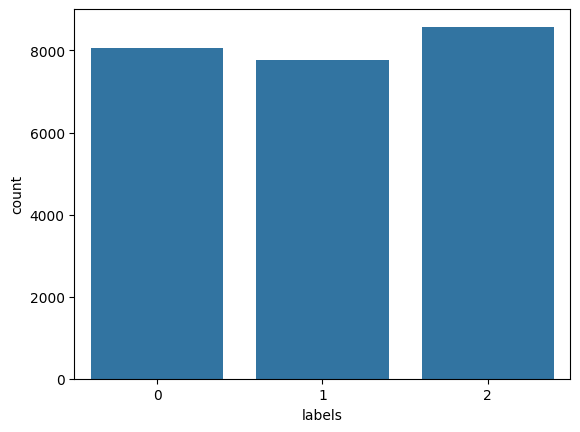

In [7]:
sns.countplot(x='labels',data=train_dataset)
plt.show()

### Split the dataset into train, validation, and test

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(train_dataset['text'],train_dataset['labels'],test_size=.1,random_state=19)
x_test = test_dataset['text'].values
y_test = test_dataset['labels'].values

print(len(x_train))
print(len(x_test))

x_train = x_train.astype(str).tolist()
x_val = x_val.astype(str).tolist()
x_test = x_test.astype(str).tolist()
y_train = y_train.astype(int).tolist()
y_val = y_val.astype(int).tolist()
y_test = y_test.astype(int).tolist()


21953
6158


### Importing the BERT classification model library

In [10]:
import tensorflow
from transformers import BertTokenizer, TFBertForSequenceClassification

2024-09-27 14:39:34.974093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 14:39:36.405625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mousaa04/miniconda3/envs/deep-l/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/home/mousaa04/miniconda3/envs/deep-l/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Tokenizing the data

In [12]:
x_train_tokenized = tokenizer(
    x_train,
    max_length = 64,
    truncation=True,
    padding='max_length',
    return_tensors='tf'
)
x_val_tokenized = tokenizer(
    x_val,
    max_length = 64,
    truncation=True,
    padding='max_length',
    return_tensors='tf'
)
x_test_tokenized = tokenizer(
    x_test,
    max_length = 64,
    truncation=True,
    padding='max_length',
    return_tensors='tf'
)


2024-09-27 14:39:42.764271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-27 14:39:42.916087: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-27 14:39:42.916409: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-27 14:39:42.919061: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-27 14:39:42.919347: I external/local_xla/xla/stream_executor

### converting target from array into tensor

In [13]:
y_train = tensorflow.convert_to_tensor(y_train,dtype=tensorflow.int32)
y_val = tensorflow.convert_to_tensor(y_val,dtype=tensorflow.int32)

### Importing the BERT Classification model

In [16]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=3, trainable=True, hidden_dropout_prob=.35,attention_probs_dropout_prob = .2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Setting up the optimizer, metrics, and loss

In [17]:
loss = tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy = tensorflow.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=2e-5)

### Compiling the model

In [18]:
model.compile(optimizer=optimizer, loss=loss,metrics=accuracy)

### Importing and setting up the Early Stopping

In [22]:
from tf_keras import callbacks


early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

### Training the model

In [23]:
history = model.fit([x_train_tokenized['input_ids'],x_train_tokenized['attention_mask']],y_train,epochs=20,batch_size=32,validation_data=([x_val_tokenized['input_ids'],x_val_tokenized['attention_mask']],y_val),callbacks=[early_stopping])

Epoch 1/20
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1727422828.868347  178559 service.cc:145] XLA service 0x7f5b5ab88fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727422828.868446  178559 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-09-27 14:40:28.873884: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-27 14:40:28.892693: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1727422828.949736  178559 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


687/687 [==============================] - 232s 268ms/step - loss: 0.9620 - accuracy: 0.5253 - val_loss: 0.8246 - val_accuracy: 0.6291
Epoch 2/20
687/687 [==============================] - 187s 272ms/step - loss: 0.8101 - accuracy: 0.6390 - val_loss: 0.7754 - val_accuracy: 0.6680
Epoch 3/20
687/687 [==============================] - 191s 278ms/step - loss: 0.7026 - accuracy: 0.6976 - val_loss: 0.6364 - val_accuracy: 0.7463
Epoch 4/20
687/687 [==============================] - 192s 279ms/step - loss: 0.6084 - accuracy: 0.7486 - val_loss: 0.5969 - val_accuracy: 0.7615
Epoch 5/20
687/687 [==============================] - 192s 279ms/step - loss: 0.5259 - accuracy: 0.7887 - val_loss: 0.5815 - val_accuracy: 0.7959
Epoch 6/20
687/687 [==============================] - 192s 280ms/step - loss: 0.4567 - accuracy: 0.8166 - val_loss: 0.5223 - val_accuracy: 0.8156
Epoch 7/20
687/687 [==============================] - 193s 281ms/step - loss: 0.3975 - accuracy: 0.8421 - val_loss: 0.4954 - val_accura

### Visualizing the train and the validation plot

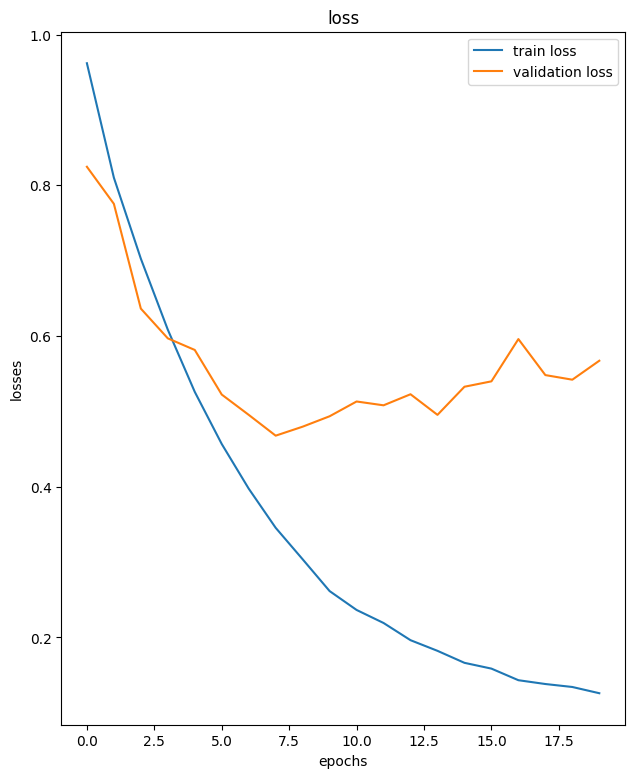

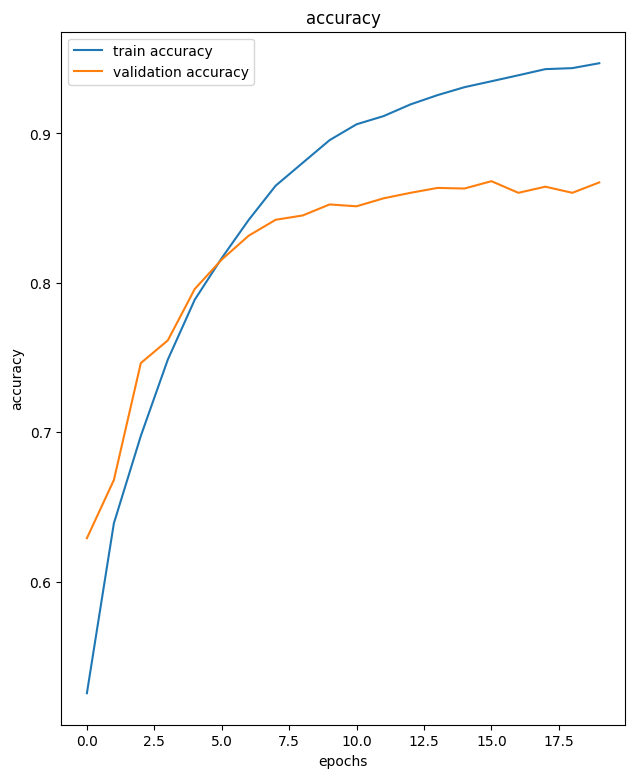

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.figure(figsize=(16,9))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

### Predicting using test data

In [25]:
y_pred = model.predict(x_test_tokenized)

193/193 [==============================] - 25s 104ms/step


### Converting the logits into the label number

In [30]:
from scipy.special import softmax
y_hasil = []
for i in range(len(y_pred[0])):
    x = softmax(y_pred[0][i])
    x = np.argmax(x)
    y_hasil.append(x)

### Calculating the accuracy

In [31]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_hasil,y_test)*100)

85.44982137057487


### Testing the model

In [44]:
sentence = "do you even have a brain?"
sentence_tokenized = tokenizer(
    sentence,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

In [45]:
sentiment_dict = {
    0:'negative',
    1:'neutral',
    2:'positive'
}
sentiment_sentence = model.predict(sentence_tokenized)
sentiment_sentence = softmax(sentiment_sentence[0][0])
sentiment_arg = np.argmax(sentiment_sentence)
print(f'sentiment of the sentence "{sentence}":{sentiment_dict[sentiment_arg]}')

1/1 [==============================] - 0s 115ms/step
sentiment of the sentence "do you even have a brain?":negative
